In [2]:
from src.vectorstorage import EmbeddingVectorStorage
from src.custom_embeddings import bge_m3_embed
from langchain_core.prompts import ChatPromptTemplate
import pandas as pd
from src.evaluation import RAGEvaluation

In [3]:
from src.config import PERSISTENT_DIR

# BAAI_bge_m3_RecursiveCharacterTextSplitter
# Alibaba-NLP_gte-Qwen2-7B_RecursiveCharacterTextSplitter
# nomic-ai_nomic-embed-text-v1_5_RecursiveCharacterTextSplitter

collection_name = "BAAI_bge_m3_RecursiveCharacterTextSplitter"

# Reload the vector store
bge_m3_vectordb = EmbeddingVectorStorage(
    method_of_embedding=bge_m3_embed,
    collection=collection_name,
    path_persistent=str(PERSISTENT_DIR),
)

print(bge_m3_vectordb)
print(bge_m3_vectordb.test_heartbeat())  # Check if the Chroma client is active
print(bge_m3_vectordb.collection_is_empty())  # Check if the collection is empty

VectorStorage(method_of_embedding=CustomHuggingFaceEndpointEmbeddings, group=BAAI_bge_m3_RecursiveCharacterTextSplitter)
1732152412127667000
False


In [4]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()
llm = ChatOpenAI(model="gpt-4o-mini")

from langchain_ollama import OllamaLLM

qwen2_5_3B = "qwen2.5:3b-instruct-q4_0"

local_llm = OllamaLLM(model=qwen2_5_3B)

basic_retriever = bge_m3_vectordb.as_retriever()

In [5]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

# https://python.langchain.com/v0.1/docs/use_cases/question_answering/sources/
# prompt: https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=2d6cd9b7-5b49-44db-a523-a13c23f12f29
basic_prompt = hub.pull("rlm/rag-prompt")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | basic_prompt
    | local_llm
    | StrOutputParser()
)

basic_rag_chain = RunnableParallel(
    {"context": basic_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

basic_rag_chain.invoke("What is the company's goal in reducing gas flaring?")

{'context': [Document(metadata={'date': '2021-12-06', 'domain': 'naturalgasintel', 'origin_doc_id': '131bdd2d071c7148b6f29f6fb64d3f4b', 'title': 'ExxonMobil Targeting Net Zero Emissions in the Permian by 2030', 'url': 'https://www.naturalgasintel.com/exxonmobil-targeting-net-zero-emissions-in-the-permian-by-2030/'}, page_content='include wind, solar, hydrogen, natural gas with carbon capture and storage, or other emerging technologies, the firm said. ExxonMobil plans to expand its methane detection programs utilizing satellite surveillance and a network of ground based sensors for continuous monitoring, and aerial flyovers that identify leaks for rapid repairs. , By the end of this year, ExxonMobil plans to reduce flaring volumes across its Permian operations by more than 75 versus 2019, and to eliminate all routine flaring in the basin by the end of 2022. The company is also securing alternative natural gas delivery points across the basin to minimize non routine flaring, management s

In [6]:
# Setup the prompt template
system_description = """You are an expert about the Clean Technology Sector.
                        Answer the user question as best you can. Answer as though you were writing a tutorial that addressed the user question."""

hyde_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_description),
        ("human", "{question}"),
    ]
)

# Define the model and output parser pipeline
gen_hypothetical_doc = hyde_prompt | local_llm | StrOutputParser()

# Setup retrieval chain
hyde_retrieval_chain = gen_hypothetical_doc | basic_retriever

# Setup RAG chain
hyde_rag_chain = RunnableParallel(
    {
        "question": RunnablePassthrough(),  # Directly passes the question through
        "context": hyde_retrieval_chain,  # Retrieves contextual information
    }
).assign(answer=basic_rag_chain)

# Invoke the system
result = hyde_rag_chain.invoke("What is the company's goal in reducing gas flaring?")

In [ ]:
result["answer"]["answer"]

In [ ]:
def format_output(response_data):
    # Extract the question
    question = response_data.get("question", "No question provided")

    # Extract context, which is a list of documents
    context = response_data.get("context", [])

    # Print the question
    print(f"Question: {question}\n")
    print("Context Documents:\n")

    # Iterate through each document in the context
    for idx, doc in enumerate(context, 1):
        metadata = doc.metadata
        page_content = doc.page_content

        # Format the metadata
        date = metadata.get("date", "Unknown date")
        domain = metadata.get("domain", "Unknown domain")
        title = metadata.get("title", "No title")
        url = metadata.get("url", "No URL provided")
        id = metadata.get("origin_doc_id")

        # Print formatted document details
        print(f"Document {idx}:")
        print(f"ID: {id}")
        print(f"Title: {title}")
        print(f"Date: {date}")
        print(f"Domain: {domain}")
        print(f"URL: {url}\n")
        print(
            f"Content: {page_content[:500]}..."
        )  # Print the first 500 characters of the content
        print("-" * 80)  # Print a line for separation

    print("\nEnd of context documents.")

In [ ]:
format_output(result)

In [ ]:
eval_df = pd.read_csv("eval_test_df.csv")

eval_df.head()

In [ ]:
def invoke_hyde_rag_and_collect_docs(question):
    # This function simulates the invocation of the RAG chain for a given question
    # and extracts the document IDs from the context provided in the response.
    result = hyde_rag.invoke(question)
    if "context" in result:
        retrieved_doc_ids = [doc.metadata["origin_doc_id"] for doc in result["context"]]
        return retrieved_doc_ids
    else:
        return []  # Return an empty list if no context is provided


# Example usage in evaluation:
eval_df["retrieved_doc_ids"] = eval_df["question"].apply(
    invoke_hyde_rag_and_collect_docs
)

In [ ]:
# print the len of the retreived doc ids
print(len(eval_df["retrieved_doc_ids"][0]))

In [7]:
from src.config import CLEAN_FILE_PATH, EVAL_FILE_PATH

# Define RAGEvaluation object
rag_eval = RAGEvaluation(
    name="Experiment HyDE",
    rag_chain=hyde_rag_chain,
    llm_model=llm,
    local_llm=local_llm.model,
    embeddings=bge_m3_embed,
)

clean_file_path = str(CLEAN_FILE_PATH)
eval_file_path = str(EVAL_FILE_PATH)

# Perform evaluation
results = rag_eval.evaluate(clean_file_path, eval_file_path, bge_m3_vectordb)

Loading cached data from: /Users/arian/Documents/FHNW/npr/npr_hs_24/npr_mc1_new_hs24/npr-mc1-frfr/data/cache/Experiment HyDE_qwen2.5:3b-instruct-q4_0_BAAI_bge_m3_gpt-4o-mini_eval_result.pkl


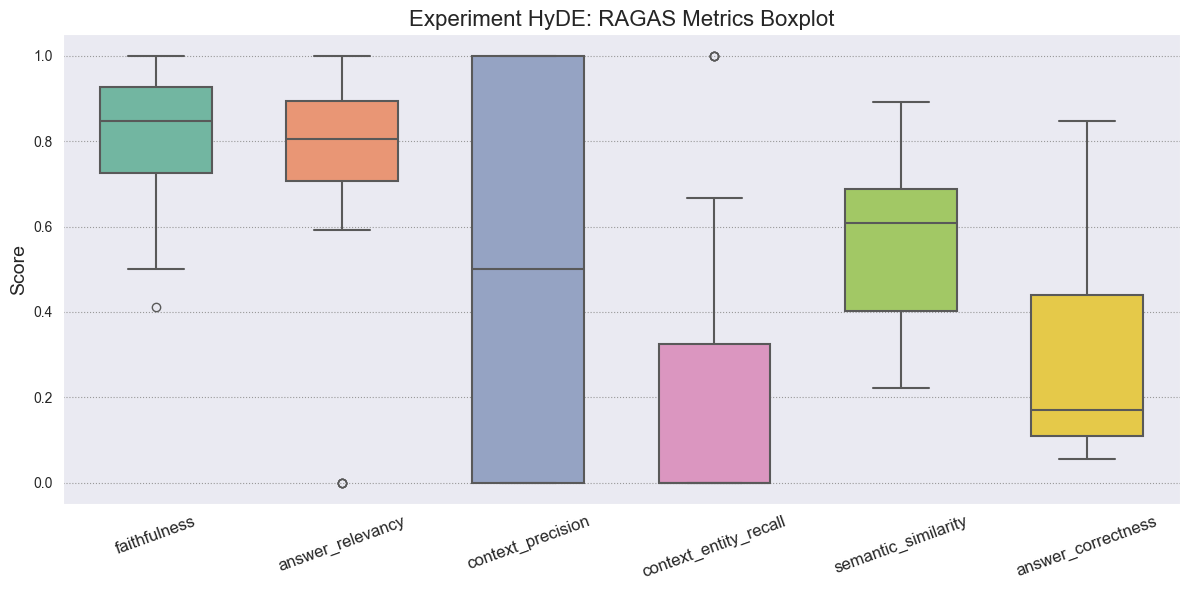

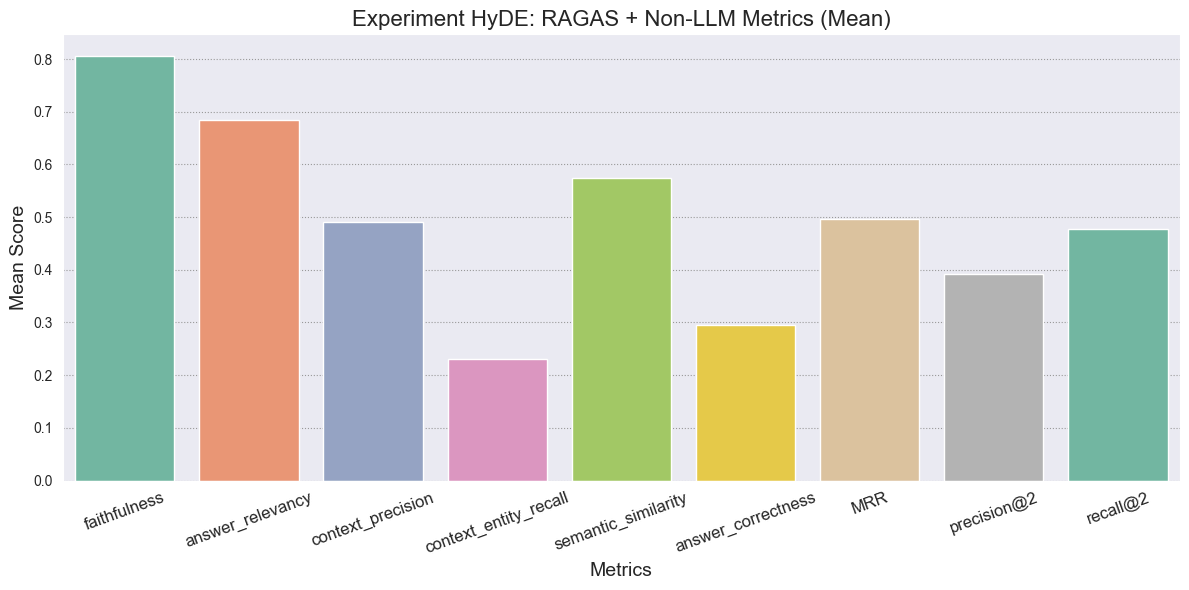

In [8]:
rag_eval.plot_results_all(results, results)